/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/1457316521.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  smallest_idx = grouped.area.idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/1457316521.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/1457316521.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  smallest_idx = grouped.area.idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel

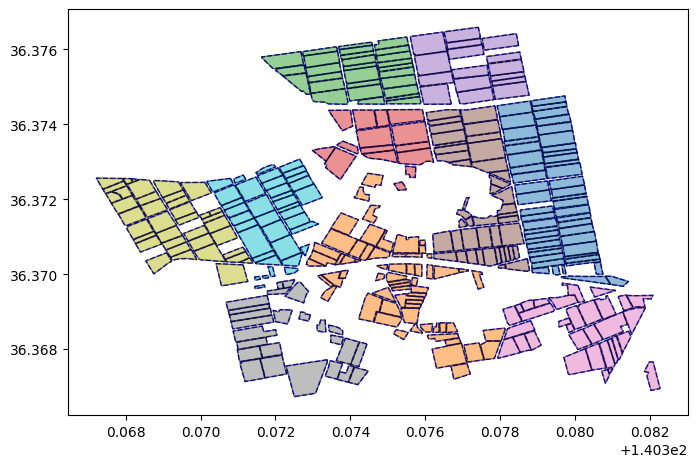

保存しました: ./data/clustered_farmland.geojson


In [33]:
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
from shapely.ops import voronoi_diagram

def load_geojson(file_path):
    return gpd.read_file(file_path)

def estimate_eps(farmland):
    """適切な eps を推定する（農地の距離分布から計算）"""
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)  # 自分自身を除外
    min_dists = np.min(dist_matrix, axis=1)
    return np.percentile(min_dists, 75)  # 75パーセンタイルの距離を eps にする

def split_largest_cluster(grouped, target_n):
    """クラスタ数が target_n より少ない場合、大きなクラスタを分割"""
    while len(grouped) < target_n:
        largest_idx = grouped.area.idxmax()
        largest_poly = grouped.loc[largest_idx].geometry

        # 重心を基に Voronoi 分割
        points = [largest_poly.centroid]
        for _ in range(2):  # 2分割する
            new_point = largest_poly.representative_point()
            points.append(new_point)

        voronoi_regions = voronoi_diagram(MultiPolygon([largest_poly]), [p for p in points])
        new_polys = [r.intersection(largest_poly) for r in voronoi_regions.geoms]

        # 分割後のポリゴンを追加
        new_geos = [p for p in new_polys if isinstance(p, Polygon)]
        grouped = grouped.drop(largest_idx)
        new_df = gpd.GeoDataFrame(geometry=new_geos)
        grouped = pd.concat([grouped, new_df]).reset_index(drop=True)
    return grouped

def cluster_farmland(farmland, target_n):
    """農地をクラスタリングして、target_n 個のクラスタに分割する

    Args:
        farmland (GeoDataFrame): 農地の GeoDataFrame
        target_n (int): 分割後のクラスタ数

    Returns:
        GeoDataFrame: クラスタリング結果
    """
    # 重心を基にクラスタリング
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    eps_value = estimate_eps(farmland)  # 自動的に eps を決定

    # DBSCAN を使用して隣接する農地をクラスタリング
    clustering = DBSCAN(eps=eps_value, min_samples=1).fit(centroids)
    farmland["cluster"] = clustering.labels_ # クラスタリング結果を追加

    grouped = farmland.dissolve(by="cluster") # dissolve: クラスタごとにまとめる
    # クラスタ数が target_n より多い場合 → 統合
    while len(grouped) > target_n:
        smallest_idx = grouped.area.idxmin()
        smallest_poly = grouped.loc[smallest_idx]
        remaining = grouped.drop(smallest_idx)
        nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
        grouped.loc[nearest_idx, "geometry"] = remaining.loc[nearest_idx].geometry.union(smallest_poly.geometry)
        grouped = grouped.drop(smallest_idx)

    # クラスタ数が target_n より少ない場合 → 分割
    grouped = split_largest_cluster(grouped, target_n)
    # groupedのタイプはGeoDataFrame

    return grouped.reset_index(drop=True) # reset_indexを使う理由は、indexを振り直すため

# ファイルパス（アップロードされたファイルを使用）
file_path = "./data/geojson_filtered_by_settlement/筑地.geojson"
farmland = load_geojson(file_path)

# グループ数を指定
n = 10  # 例: 10個の区画
clustered_farmland = cluster_farmland(farmland, n)

# カラーマップの設定
num_clusters = len(clustered_farmland)
colors = plt.cm.get_cmap("tab10", num_clusters).colors  # カラーマップを使用

# 結果の可視化
fig, ax = plt.subplots(figsize=(8, 8))
farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")

for idx, (geom, color) in enumerate(zip(clustered_farmland.geometry, colors)):
    gpd.GeoSeries([geom]).plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {idx}")

# plt.legend()
plt.show()

# 結果を GeoJSON として保存
output_path = "./data/clustered_farmland.geojson"
clustered_farmland.to_file(output_path, driver="GeoJSON")
print(f"保存しました: {output_path}")


In [28]:
# Geojsonに保存する際に、parameterの中にcluster_idというキーを作り、その中にクラスター番号を入れる
clustered_farmland["cluster_id"] = clustered_farmland.index

# 結果を GeoJSON として保存
output_path = "./data/clustered_farmland_with_cluster_id.geojson"
clustered_farmland.to_file(output_path, driver="GeoJSON")
print(f"保存しました: {output_path}")

保存しました: ./data/clustered_farmland_with_cluster_id.geojson


In [31]:
clustered_farmland.iloc[1]

geometry                                     MULTIPOLYGON (((140.375705852 36.368682359, 14...
polygon_uuid                                              b1ac1621-bdaa-4238-86b2-48ac10b83a09
land_type                                                                                  100
issue_year                                                                                2024
edit_year                                                                                 2020
history                                      [ { "筆ポリゴンID": "8fe1e6ce-895d-4d9a-8d32-dd0834...
last_polygon_uuid                                         8fe1e6ce-895d-4d9a-8d32-dd08347f959d
prev_last_polygon_uuid                                    c14a425b-6382-4aa9-8b8e-48c6455146cf
local_government_cd                                                                     082015
point_lng                                                                           140.375668
point_lat                                         

/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  smallest_idx = grouped.area.idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  smallest_idx = grouped.area.idxmin()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel

フレーム 1 を保存しました: ./data/frames/frame_1.png
フレーム 2 を保存しました: ./data/frames/frame_2.png


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that arti

フレーム 3 を保存しました: ./data/frames/frame_3.png
フレーム 4 を保存しました: ./data/frames/frame_4.png


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that arti

フレーム 5 を保存しました: ./data/frames/frame_5.png
フレーム 6 を保存しました: ./data/frames/frame_6.png


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that arti

フレーム 7 を保存しました: ./data/frames/frame_7.png
フレーム 8 を保存しました: ./data/frames/frame_8.png


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


フレーム 9 を保存しました: ./data/frames/frame_9.png
フレーム 10 を保存しました: ./data/frames/frame_10.png
すべてのフレームが保存されました。保存先: ./data/frames


/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/3x/t05685j130vgh1jgcmlkr9tc0000gn/T/ipykernel_64761/3529642028.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


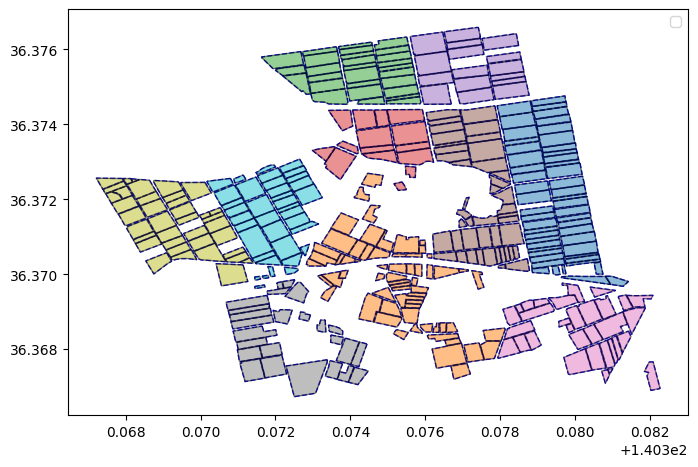

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from sklearn.cluster import DBSCAN
from shapely.ops import voronoi_diagram
import os

def load_geojson(file_path):
    return gpd.read_file(file_path)

def estimate_eps(farmland):
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = np.min(dist_matrix, axis=1)
    return np.percentile(min_dists, 75)

def split_largest_cluster(grouped, target_n):
    while len(grouped) < target_n:
        largest_idx = grouped.area.idxmax()
        largest_poly = grouped.loc[largest_idx].geometry
        points = [largest_poly.centroid]
        for _ in range(2):
            new_point = largest_poly.representative_point()
            points.append(new_point)
        voronoi_regions = voronoi_diagram(MultiPolygon([largest_poly]), [p for p in points])
        new_polys = [r.intersection(largest_poly) for r in voronoi_regions.geoms]
        new_geos = [p for p in new_polys if isinstance(p, Polygon)]
        grouped = grouped.drop(largest_idx)
        new_df = gpd.GeoDataFrame(geometry=new_geos)
        grouped = pd.concat([grouped, new_df]).reset_index(drop=True)
    return grouped

def cluster_farmland(farmland, target_n):
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    eps_value = estimate_eps(farmland)
    clustering = DBSCAN(eps=eps_value, min_samples=1).fit(centroids)
    farmland["cluster"] = clustering.labels_
    grouped = farmland.dissolve(by="cluster")
    while len(grouped) > target_n:
        smallest_idx = grouped.area.idxmin()
        smallest_poly = grouped.loc[smallest_idx]
        remaining = grouped.drop(smallest_idx)
        nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
        grouped.loc[nearest_idx, "geometry"] = remaining.loc[nearest_idx].geometry.union(smallest_poly.geometry)
        grouped = grouped.drop(smallest_idx)
    grouped = split_largest_cluster(grouped, target_n)
    return grouped.reset_index(drop=True)

# ファイルパス
file_path = "./data/geojson_filtered_by_settlement/筑地.geojson"
farmland = load_geojson(file_path)

# グループ数を指定
n = 10
clustered_farmland = cluster_farmland(farmland, n)

# カラーマップの設定
num_clusters = len(clustered_farmland)
colors = plt.cm.get_cmap("tab10", num_clusters).colors

# 保存先ディレクトリを作成
output_dir = "./data/frames"
os.makedirs(output_dir, exist_ok=True)

# 各フレームを画像として保存
fig, ax = plt.subplots(figsize=(8, 8))

def save_frame(i):
    ax.clear()  # プロットをクリア
    farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")
    for idx, (geom, color) in enumerate(zip(clustered_farmland.geometry[:i+1], colors)):
        gpd.GeoSeries([geom]).plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {idx}")
    plt.legend()

    # 画像として保存
    frame_path = os.path.join(output_dir, f"frame_{i+1}.png")
    plt.savefig(frame_path)
    print(f"フレーム {i+1} を保存しました: {frame_path}")

# 各フレームを保存
for i in range(len(clustered_farmland)):
    save_frame(i)

print(f"すべてのフレームが保存されました。保存先: {output_dir}")


In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
from shapely.ops import voronoi_diagram

def load_geojson(file_path):
    return gpd.read_file(file_path)

def estimate_eps(farmland):
    """適切な eps を推定する（農地の距離分布から計算）"""
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)  # 自分自身を除外
    min_dists = np.min(dist_matrix, axis=1)
    return np.percentile(min_dists, 75)  # 75パーセンタイルの距離を eps にする

def split_largest_cluster(grouped, target_n):
    """クラスタ数が target_n より少ない場合、大きなクラスタを分割"""
    while len(grouped) < target_n:
        largest_idx = grouped.area.idxmax()
        largest_poly = grouped.loc[largest_idx].geometry

        # 重心を基に Voronoi 分割
        points = [largest_poly.centroid]
        for _ in range(2):  # 2分割する
            new_point = largest_poly.representative_point()
            points.append(new_point)

        voronoi_regions = voronoi_diagram(MultiPolygon([largest_poly]), [p for p in points])
        new_polys = [r.intersection(largest_poly) for r in voronoi_regions.geoms]

        # 分割後のポリゴンを追加
        new_geos = [p for p in new_polys if isinstance(p, Polygon)]
        grouped = grouped.drop(largest_idx)
        new_df = gpd.GeoDataFrame(geometry=new_geos)
        grouped = pd.concat([grouped, new_df]).reset_index(drop=True)
    return grouped

def cluster_farmland(farmland, target_n):
    centroids = np.array([geom.centroid.coords[0] for geom in farmland.geometry])
    eps_value = estimate_eps(farmland)  # 自動的に eps を決定

    # DBSCAN を使用して隣接する農地をクラスタリング
    clustering = DBSCAN(eps=eps_value, min_samples=1).fit(centroids)
    farmland["cluster"] = clustering.labels_

    grouped = farmland.dissolve(by="cluster")

    # クラスタ数が target_n より多い場合 → 統合
    while len(grouped) > target_n:
        smallest_idx = grouped.area.idxmin()
        smallest_poly = grouped.loc[smallest_idx]
        remaining = grouped.drop(smallest_idx)
        nearest_idx = remaining.distance(smallest_poly.geometry).idxmin()
        grouped.loc[nearest_idx, "geometry"] = remaining.loc[nearest_idx].geometry.union(smallest_poly.geometry)
        grouped = grouped.drop(smallest_idx)

    # クラスタ数が target_n より少ない場合 → 分割
    grouped = split_largest_cluster(grouped, target_n)

    return grouped.reset_index(drop=True) # インデックスを振り直して返す

# ファイルパス（アップロードされたファイルを使用）
file_path = "./data/geojson_filtered_by_settlement/筑地.geojson"
farmland = load_geojson(file_path)

# グループ数を指定
n = 10  # 例: 10個の区画
clustered_farmland = cluster_farmland(farmland, n)

# カラーマップの設定
num_clusters = len(clustered_farmland)
colors = plt.cm.get_cmap("tab10", num_clusters).colors  # カラーマップを使用

# 結果の可視化
fig, ax = plt.subplots(figsize=(8, 8))
farmland.plot(ax=ax, facecolor="none", edgecolor="blue", linestyle="--")

for idx, (geom, color) in enumerate(zip(clustered_farmland.geometry, colors)):
    gpd.GeoSeries([geom]).plot(ax=ax, facecolor=color, edgecolor="black", alpha=0.5, label=f"Cluster {idx}")

plt.legend()
plt.show()

# Geojsonに保存する際に、parameterの中にcluster_idというキーを作り、その中にクラスター番号を入れる
clustered_farmland["parameter"] = clustered_farmland["cluster"]
clustered_farmland = clustered_farmland.drop("cluster", axis=1)

# 結果を GeoJSON として保存
